# RL Agent Using Q-Learning Algorithm


- Environment: [MountainCar](https://gym.openai.com/envs/MountainCar-v0/)
- Policy: Epsilon Gready Policy
- Number of Actions: 3
- Number of States: 201 * 201 * 3 = 121,203


Developed by:
- Daniel Addai-Marnu <daniel.addai-marnu@city.ac.uk>

## Description of Environment

A car is on a one-dimensional track, positioned between two "mountains". The goal is to drive up the mountain on the right; however, the car's engine is not strong enough to scale the mountain in a single pass. Therefore, the only way to succeed is to drive back and forth to build up momentum.

Details about the states, reward and solved policy is available here: https://github.com/openai/gym/wiki/MountainCar-v0

# How to Run the Notebook

Upload the notebook to [Google Colab](https://colab.research.google.com/notebooks/intro.ipynb#recent=true) and run the notebook. This will install ensure all python requirements are available to execute the notebook. 

# Install and Import Packages

In [0]:
!pip install -q -U gym
!apt-get install python-opengl -y -qq
!apt install xvfb -y -qq

!pip install -q pyvirtualdisplay piglet millify

Selecting previously unselected package python-opengl.
(Reading database ... 144433 files and directories currently installed.)
Preparing to unpack .../python-opengl_3.1.0+dfsg-1_all.deb ...
Unpacking python-opengl (3.1.0+dfsg-1) ...
Setting up python-opengl (3.1.0+dfsg-1) ...
The following NEW packages will be installed:
  xvfb
0 upgraded, 1 newly installed, 0 to remove and 31 not upgraded.
Need to get 784 kB of archives.
After this operation, 2,266 kB of additional disk space will be used.
Selecting previously unselected package xvfb.
(Reading database ... 146788 files and directories currently installed.)
Preparing to unpack .../xvfb_2%3a1.19.6-1ubuntu4.4_amd64.deb ...
Unpacking xvfb (2:1.19.6-1ubuntu4.4) ...
Setting up xvfb (2:1.19.6-1ubuntu4.4) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
     |████████████████████████████████| 71kB 3.4MB/s 
     |████████████████████████████████| 92kB 8.0MB/s 


In [0]:
import sys
import math
import glob
import io
import base64
from itertools import count
import math
import time
from collections import defaultdict, deque
from datetime import datetime
from dataclasses import dataclass
import os

import gym
from gym import logger as gymlogger
from gym.wrappers import Monitor
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
from pyvirtualdisplay import Display
from IPython.display import HTML
from IPython import display as ipythondisplay
from millify import millify
# setup gym display for virtual environment when running in Google Colab
gymlogger.set_level(40) # error only

IS_COLAB = 'google.colab' in sys.modules

if IS_COLAB:
    display = Display(visible=0, size=(1400, 900))
    display.start()

# set up matplotlib
%matplotlib inline
is_ipython = 'inline' in matplotlib.get_backend()
matplotlib.style.use('ggplot')
matplotlib.rcParams['figure.dpi']= 110
sns.set_style('darkgrid')

# function to view recorded training videos
def show_video(recording_dir='video', index=-1):
    """
    Utility functions to enable video recording of gym environment and displaying it
    To enable video, just do "env = wrap_env(env)""
    """
    mp4list = glob.glob('./recordings/{}/*.mp4'.format(recording_dir))
    if len(mp4list) > 0:
        mp4 = mp4list[index]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                    loop controls style="height: 400px;">
                    <source src="data:video/mp4;base64,{0}" type="video/mp4" />
                </video>'''.format(encoded.decode('ascii'))))
    else: 
        print("Could not find video")


# gym monitor wrapper
def wrap_env(env, recording_dir='video'):
    env = Monitor(env, './recordings/'+recording_dir, force=True)
    return env

# ensure output folders are created
os.makedirs('models', exist_ok=True)
os.makedirs('metrics', exist_ok=True)
os.makedirs('charts', exist_ok=True)
os.makedirs('recordings', exist_ok=True)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
xdpyinfo was not found, X start can not be checked! Please install xdpyinfo!


# Test environment

Here we load the MountainCar-v0 and test how it works

In [0]:
# load the environment
env = gym.make('MountainCar-v0')
# wrap the environment with the video recorder for rendering online
env = wrap_env(env)

# get initial observation
observation = env.reset()
total_reward = 0
# execute some random actions
for timesteps in count(start=1):
    action = env.action_space.sample()
    next_state, reward, is_done, info = env.step(action)
    total_reward += reward

    if is_done:
        print("Task completed in {} steps || total reward: {}".format(timesteps, total_reward))
        break

env.close()
show_video() # show video in colab

Task completed in 200 steps || total reward: -200.0


For each step taken, the agent receives a reward of -1 until it reaches the goal position (indicated with the flag). There is limited time of 200 steps to complete the task. The reward system makes it difficult for the agent to learn from the actions taken. For this reason we'll adjust the reward for the environment accordingly

# Adjust Environment Reward

We adjusted the reward by adding 0.5 to the location of the car for each action and +100 for reaching the goal position. This is to ensure the agent learns to take action that moves the car upward.

In [0]:
class RewardWrapper(gym.Wrapper):

    def __init__(self, env):
        super().__init__(env)

    def step(self, action):
        """
        Adjust reward based on car's position and tasks completion
        """
        # observation = (position, velocity)
        observation, reward, done, info = self.env.step(action)
        # set counter for goal position
        info['goal_position'] = 0
        # adjust reward based on car's position
        modified_reward = reward
        if observation[0] >= self.env.goal_position:  # goal location
            modified_reward = 100
            info['goal_position'] = 1
        elif observation[0] > -0.4: # starting position
            modified_reward += observation[0] + 0.5
        info['modified_reward'] = modified_reward
                
        return observation, reward, done, info

# Q Learning

### Define helper functions to train the agent

In [0]:
class Metrics:
    """
    Class to accumate scores during the training process
    e.g.
    metrics = Metrics()
    metrics.add('steps', 120) 
    metrics.save('agent') # write metrics to csv
    """

    def __init__(self):
        self.data = defaultdict(list)

    def add(self, key, record):
        self.data[key].append(record)

    def __getitem__(self, key: str):
        return self.data[key]

    def to_dataframe(self):
        return pd.DataFrame(self.data)
    
    def save(self, path):
        df = self.to_dataframe()
        df.to_csv('metrics/{}.csv'.format(path), index=False)

    
@dataclass
class ArgmaxActionSelector:
    """
    Selects actions using argmax
    """
    def __call__(self, scores):
        return np.argmax(scores)
    

@dataclass
class EpsilonGreedyStrategy():
    """
    Selects actions using Epsilon Greedy Policy. Initialte the class with the starting epsilon value,
    min value and decay rate. For each timestep the epsilon is reduced by the decay rate until it
    reaches the minimum value.
    """
    start: float
    end: float
    decay: float
    
    def __call__(self, scores):
        if random.random() < self.start:
            # Epsilon-Greedy action exploration
            action = random.randrange(0, scores.shape[0], 1)
        else:
            # use exploitation
            action = np.argmax(scores)
        
        # decrease epsilon
        if self.start > self.end:
            self.start *= self.decay
        return int(action)


class QAgent:
    """
    Q agent contains function to implement the q-learning algorithm to solve the environment
    """
    def __init__(self, env, strategy, discrete_states=30, alpha=0.05, gamma=0.98, policy_path='qagent'):
        """
        Initialize a new Q agent for a given environment and learning parameters
        :param env: OpenAI Gym environment
        :param strategy: Action selection strategy
        :param discrete_states: Number of states to discritize the environment's observations
        :param alpha: learning rate for the bellman equation
        :param gamma: Discount factor
        :param policy_path: Path to save model
        """
        self.env = env
        self.obs_shape = env.observation_space.shape
        self.obs_high = env.observation_space.high
        self.obs_low = env.observation_space.low
        # Number of bins to Discretize each observation dim
        self.obs_bins = discrete_states 
        self.bin_width = (self.obs_high - self.obs_low) / self.obs_bins
        self.action_space = env.action_space
        # Create a multi-dimensional array to represent the Q-values
        self.Q = np.zeros((self.obs_bins + 1, self.obs_bins + 1, self.action_space.n), dtype=float)  # (201 x 201 x 3)
        # set learning parameters
        self.strategy = strategy
        self.alpha = alpha  # Learning rate
        self.gamma = gamma  # Discount factor
        self.steps_counter = 0
        self.policy_path = policy_path

    def __repr__(self):
        return f"QAgent(alpha={self.alpha}, gamma={self.gamma}, strategy={self.strategy})"

    def discretize(self, obs):
        """
        This function place each observation into discrete number of bins 
        to enable a tabular representation of the observations. 
        """
        return tuple(((obs - self.obs_low) / self.bin_width).astype(int))

    def act(self, obs):
        """
        Agent choose action based on the policy given
        """
        # retrieve the Q-values for the given state
        scores = self.Q[self.discretize(obs)]
        # apply strategy to decide actions
        action = self.strategy(scores)
        return action

    def learn(self, obs, action, reward, next_obs):
        """
        Function to make agent learn by computing and updating the Q values
        """
        state = self.discretize(obs)
        next_state = self.discretize(next_obs)

        if next_obs[0] >= self.env.goal_position: #Allow for terminal states
            self.Q[state][action] = reward
            return
        # max(Q'(S', a')): best q value from the table for the next state
        max_q_state = np.max(self.Q[next_state])
        # Q(s, a): the q value for the current state
        q_state = self.Q[state][action]
        # calculate new q value
        # Q(s, a) + α[R(s,a) + γ[max(Q'(S', a'))] - Q(s, a)]
        target_q = q_state + self.alpha * (reward + (self.gamma * max_q_state) - q_state)
        # update q-table
        self.Q[state][action] = target_q

    def get_policy(self):
        """
        Return the trained policy. The maximum Q-values for all states
        """
        return np.argmax(self.Q, axis=2)

    def save_policy(self):
        """
        Save the Q-values as numpy object
        """
        np.save('models/{}'.format(self.policy_path), self.Q)

### Define agent training functions

In [0]:
def print_progress(str):
    """Function print progress"""
    print(str)
    ipythondisplay.clear_output(wait=True)


def train(agent, env, episodes=10000):
    """
    Function to train an agent for a given environment and number of episodes
    """
    print('Training agent for {} episodes'.format(episodes))
    # initialize best average reward
    best_reward = -math.inf
    # initialize metrics container
    metrics = Metrics()
    # initialize starting time
    start_time = time.time()
    # number of completion streaks
    goal_position_streaks = 0
    # start episode interaction
    for episode in range(1, episodes+1):
        obs = env.reset()
        total_reward = 0.0
        # train agent to solve the environment
        for timesteps in count(start=1):
            # agent makes decision
            action = agent.act(obs)
            # execute action on environment
            next_state, reward, done, info = env.step(action)
            # cumulate episode reward
            total_reward += reward
            # make agent learn 
            modified_reward = info['modified_reward']
            agent.learn(obs, action, modified_reward, next_state)
            # update previous state with next state
            obs = next_state
            # check if environment is solved
            if done:
                # track consecutive goal streaks
                goal_position_streaks += info['goal_position']
                # update metrics
                metrics.add('steps', timesteps)
                metrics.add('rewards', total_reward)
                metrics.add('goal_positions', info['goal_position'])
                break

        # update best reward
        if total_reward > best_reward:
            best_reward = total_reward
    
        if episode % 100 == 0:
            print_progress('Episode#: {}/{}, steps: {}, reward: {}, best reward: {}, goal position streaks: {}'.format(
                episode, episodes, timesteps, total_reward, best_reward, goal_position_streaks)
            )
        # MountainCar-v0 defines "solving" as getting average reward of -110.0 over 100 consecutive trials.
        # https://github.com/openai/gym/wiki/MountainCar-v0#solved-requirements
        last_100_average_reward = np.mean(metrics['rewards'][-100:])
        if last_100_average_reward >= -110:
            print("\n Task complete \n")
            break
            
        if episode % 10000 == 0: # period saving of policy to prevent retraining when it crashes
            agent.save_policy()

    time_elapsed = time.time() - start_time
    print('Training complete in {} episodes || Best reward: {:.2f} || Time spent: {:.0f}m {:.0f}s, streaks: {}'.format(
        episode, best_reward, time_elapsed // 60, time_elapsed % 60, goal_position_streaks
    ))
    agent.save_policy()
    # close environment
    env.close()
    # return metrics
    metrics.save(agent.policy_path)
    return metrics.to_dataframe()


def test(agent, env, episodes=100):
    """
    Function to test a trained agent for athe given environment
    """
    # get the trained policy - Q-table
    policy = agent.get_policy()
    metrics = Metrics()

    for _ in range(episodes):
        obs = env.reset()
        total_reward = 0.0
        for timesteps in count(start=1):
            # select action from the best Q-values
            action = policy[agent.discretize(obs)]
            next_state, reward, done, info = env.step(action)
            obs = next_state
            total_reward += reward

            if done:
                break

        metrics.add('rewards', total_reward)
        metrics.add('steps', timesteps)
        metrics.add('goal_position', info['goal_position'])
    # close environment
    env.close()
    return metrics.to_dataframe()

# Train the Q-Agent

In [0]:
def make_env(recording_dir='videos', max_episode_steps=500):
    """Create environment with higher timelimit and reward changes"""
    env = gym.make('MountainCar-v0')
    env = gym.wrappers.TimeLimit(env.unwrapped, max_episode_steps=max_episode_steps)
    env = wrap_env(env, recording_dir=recording_dir)
    env = RewardWrapper(env)
    # to ensure reproducibility
    env.seed(110)
    np.random.seed(10)
    return env


def plot_scores(metrics, rolling_window=100, title="Training scores", format_ticks=True, filename='qagent'):
    """Plot scores and optional rolling mean using specified window."""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4), sharex=True)
    
    rolling_means = metrics.rolling(rolling_window).mean()
    
    ax1.plot(metrics['steps'], label="Time steps", alpha=0.3, linewidth=1, markersize=5)
    ax1.plot(rolling_means['steps'], label="Moving average", linewidth=1, markersize=0.5)
    ax1.set_xlabel("Episodes")
    ax1.set_title("Steps")
    if format_ticks:
        xticks = [millify(x) for x in ax1.get_xticks()]
        ax1.set_xticklabels(xticks)

    ax1.legend(loc='best')
    
    ax2.plot(metrics['rewards'], label="Rewards", alpha=0.3, linewidth=1, markersize=0.5)
    ax2.plot(rolling_means['rewards'], label="Moving average", linewidth=1, markersize=0.5)
    ax2.set_title("Rewards")
    ax2.legend(loc='best')
    ax2.set_xlabel("Episodes")
    if format_ticks:
        xticks = [millify(x) for x in ax2.get_xticks()]
        ax2.set_xticklabels(xticks)
    
    plt.suptitle(title)
    plt.savefig('charts/scores_{}.jpg'.format(filename))
    plt.show()


def plot_q_table(q_table, filename='qagent'):
    """Visualize max Q-value for each state and corresponding action."""
    q_image = np.max(q_table, axis=2)       # max Q-value for each state
    q_actions = np.argmax(q_table, axis=2)  # best action for each state

    fig, ax = plt.subplots(figsize=(10, 10))
    cax = ax.imshow(q_image, cmap='jet');
    cbar = fig.colorbar(cax)
    for x in range(q_image.shape[0]):
        for y in range(q_image.shape[1]):
            ax.text(x, y, q_actions[x, y], color='white',
                    horizontalalignment='center', verticalalignment='center')
    ax.grid(False)
    ax.set_title("Q-table, size: {}".format(q_table.shape))
    ax.set_xlabel('position')
    ax.set_ylabel('velocity')
    
    plt.savefig('charts/qtable_{}.jpg'.format(filename))
    plt.show()

In [0]:
# define training parameters
NUM_EPISODES = 200000 # two hundred thousand episodes
DISCRETE_STATES = 200  # discritize states into 201*201 bins

## Trial 1

```
Epsilon values: start=0.9, end=0.01, decay=0.9999995
Alpha = 0.05
Gamma = 0.98
```

In [0]:
# load environment 
env = make_env(recording_dir='agent1')
env

<RewardWrapper<Monitor<TimeLimit<MountainCarEnv<MountainCar-v0>>>>>

In [0]:
# define agent strategy
strategy = EpsilonGreedyStrategy(start=0.9, end=0.01, decay=0.9999995)
# create agent
agent1 = QAgent(env, strategy, discrete_states=DISCRETE_STATES, alpha=0.05, gamma=0.98, policy_path='agent1')
agent1

QAgent(alpha=0.05, gamma=0.98, strategy=EpsilonGreedyStrategy(start=0.9, end=0.01, decay=0.9999995))

In [0]:
# start the training process
metrics = train(agent1, env, episodes=NUM_EPISODES)


 Task complete 

Training complete in 176291 episodes || Best reward: -88.00 || Time spent: 60m 40s, streaks: 156064


The agent completed solving the environment in 176291 episodes and 60 minutes with best reward of -88

In [0]:
# show the training video. In colab the, the environment video does not show up. 
# Calling the function below will show the record training steps.
show_video('agent1')

### Visualize training scores

In [0]:
metrics.tail(100)

,steps,rewards,goal_positions
176191,90,-90.0,1
176192,93,-93.0,1
176193,158,-158.0,1
176194,89,-89.0,1
176195,120,-120.0,1
...,...,...,...
176286,97,-97.0,1
176287,118,-118.0,1
176288,116,-116.0,1
176289,97,-97.0,1


We observe the steps and reward for each episode. The goal_positions column, indicate whether the reached the flag (1) or the environment run out of steps (0).

In [0]:
metrics.describe()

,steps,rewards,goal_positions
count,176291.000000,176291.000000,176291.000000
mean,222.672717,-222.672717,0.885264
std,124.947323,124.947323,0.318704
min,88.000000,-500.000000,0.000000
25%,130.000000,-251.000000,1.000000
50%,165.000000,-165.000000,1.000000
75%,251.000000,-130.000000,1.000000
max,500.000000,-88.000000,1.000000


It took about 176291 episodes for the agent to complete training. The environment is considered when the average of the last 100 episodes is less or equal to -110

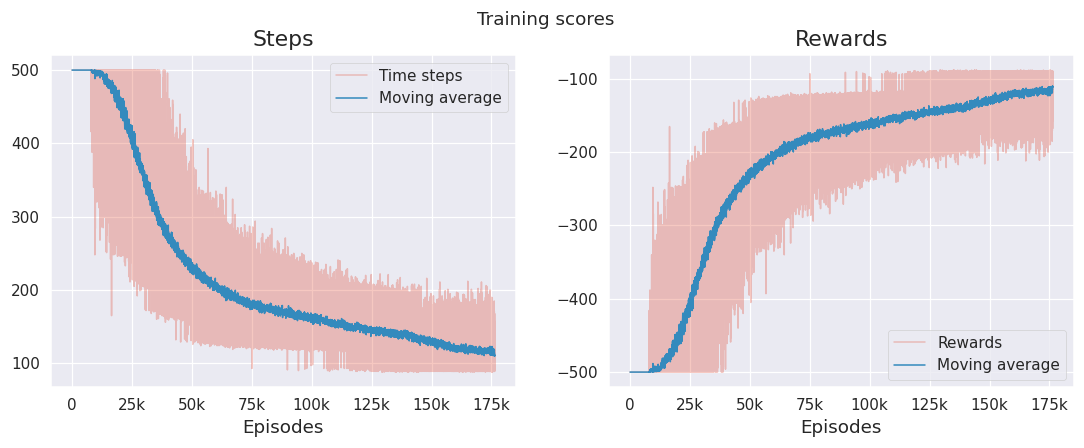

In [0]:
plot_scores(metrics, rolling_window=100)

You should observe the mean episode timesteps go down over time while the average reward increase over time. Next, we freeze learning and run the agent in test mode to see how well it performs.

### Test agent on the environment

We used the trained Q-table to solve the environment.

In [0]:
# test the trained policy for 100 episodes
test_df = test(agent1, env)

In [0]:
test_df.tail(100)

,rewards,steps,goal_position
0,-116.0,116,1
1,-90.0,90,1
2,-90.0,90,1
3,-115.0,115,1
4,-93.0,93,1
...,...,...,...
95,-95.0,95,1
96,-92.0,92,1
97,-118.0,118,1
98,-121.0,121,1


In [0]:
test_df.describe()

,rewards,steps,goal_position
count,100.000000,100.000000,100.0
mean,-111.240000,111.240000,1.0
std,20.411979,20.411979,0.0
min,-165.000000,89.000000,1.0
25%,-120.000000,92.000000,1.0
50%,-116.000000,116.000000,1.0
75%,-92.000000,120.000000,1.0
max,-89.000000,165.000000,1.0


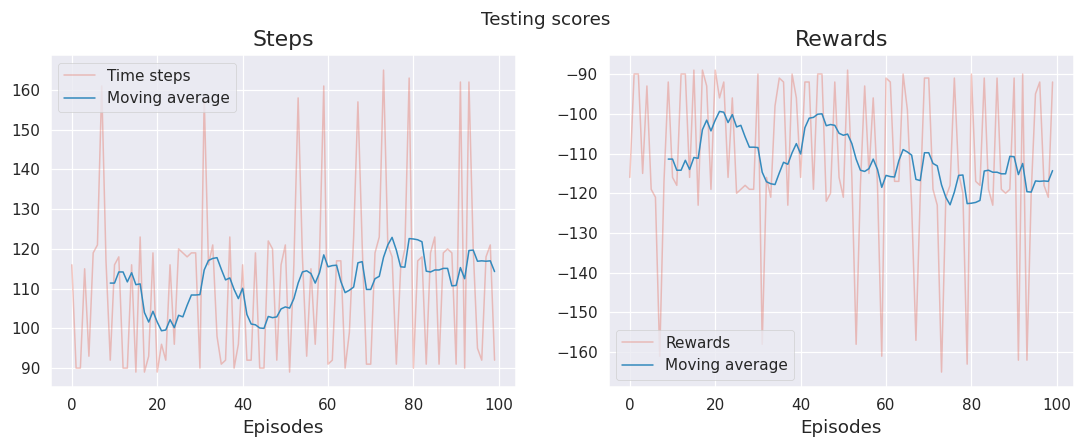

In [0]:
# visualize the test scores
plot_scores(test_df, rolling_window=10, title='Testing scores', format_ticks=False, filename='qagent_test')

We expect the average to fall below -110 for the best case scenario.

### Plot Q-table

It's also interesting to look at the final Q-table that is learned by the agent. Note that the Q-table is of size MxNxA, where (M, N) is the size of the state space, and A is the size of the action space. We are interested in the maximum Q-value for each state, and the corresponding (best) action associated with that value.

In [0]:
# display the Q-table
agent1.get_policy()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

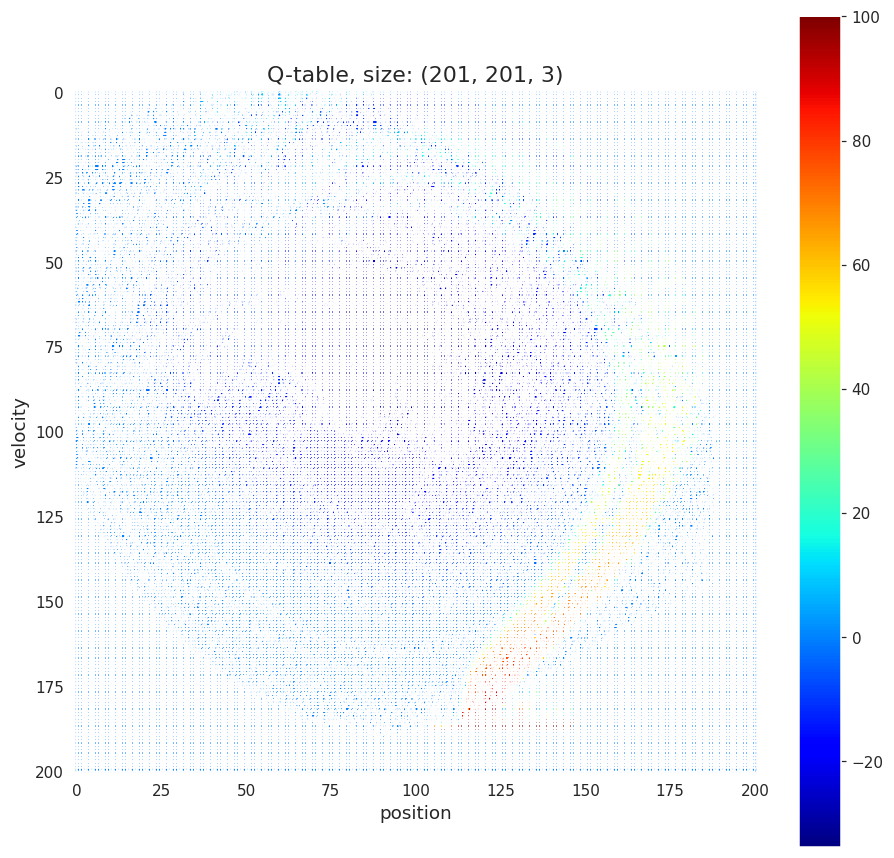

In [0]:
plot_q_table(agent1.Q)

We can observe the position of the Q-values with the best reward indicated in red color

## Trial 2 - Increase epsilon while keeping alpah and gamma constant

```
Epsilon values: start=1, end=0.09, decay=0.9999995
Alpha = 0.05
Gamma = 0.98
```

In [0]:
# load environment 
env = make_env(recording_dir='agent2')
env

<RewardWrapper<Monitor<TimeLimit<MountainCarEnv<MountainCar-v0>>>>>

In [0]:
# define agent strategy
strategy = EpsilonGreedyStrategy(start=1, end=0.09, decay=0.9999995)
# create agent
agent2 = QAgent(env, strategy, discrete_states=DISCRETE_STATES, alpha=0.05, gamma=0.98, policy_path='agent2')
agent2

QAgent(alpha=0.05, gamma=0.98, strategy=EpsilonGreedyStrategy(start=1, end=0.09, decay=0.9999995))

In [0]:
# start the training process
metrics2 = train(agent2, env, episodes=NUM_EPISODES)

Training complete in 200000 episodes || Best reward: -85.00 || Time spent: 66m 27s, streaks: 179399


The agent completed solving the environment in 217 minutes with best reward of -83

In [0]:
# show the video
show_video('agent2')

### Visualize training scores

In [0]:
metrics2.tail(100)

,steps,rewards,goal_positions
199900,117,-117.0,1
199901,120,-120.0,1
199902,120,-120.0,1
199903,117,-117.0,1
199904,194,-194.0,1
...,...,...,...
199995,164,-164.0,1
199996,147,-147.0,1
199997,87,-87.0,1
199998,146,-146.0,1


In [0]:
metrics2.describe()

,steps,rewards,goal_positions
count,200000.000000,200000.000000,200000.000000
mean,225.348750,-225.348750,0.896995
std,117.320461,117.320461,0.303966
min,85.000000,-500.000000,0.000000
25%,153.000000,-249.000000,1.000000
50%,168.000000,-168.000000,1.000000
75%,249.000000,-153.000000,1.000000
max,500.000000,-85.000000,1.000000


It took about 800k episodes for each the agent to complete training. The environment is considered when the average of the last 100 episodes is less or equal to -110

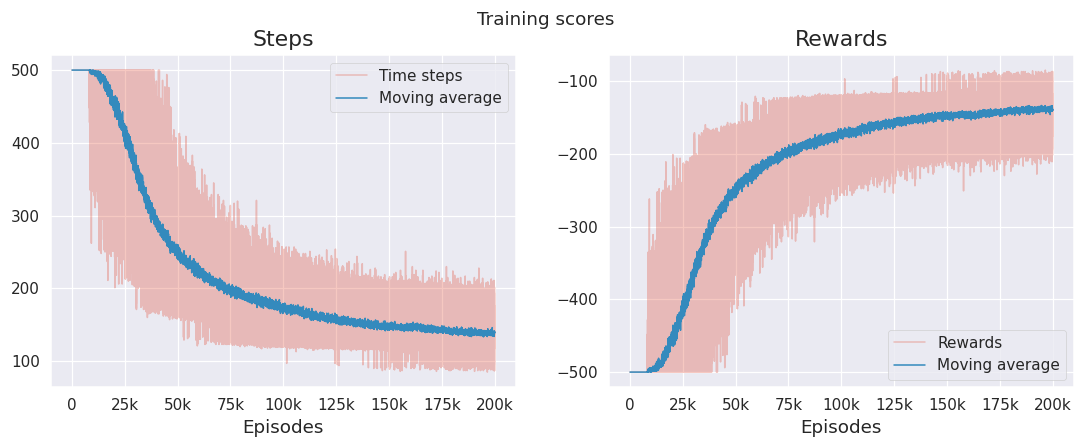

In [0]:
plot_scores(metrics2, rolling_window=100)

You should observe the mean episode timesteps go down over time while the average reward increase over time. Next, we freeze learning and run the agent in test mode to see how well it performs.

### Test agent on the environment

We used the trained Q-table to solve the environment.

In [0]:
# test the trained policy for 100 episodes
test_df2 = test(agent2, env)

In [0]:
test_df2.tail(100)

,rewards,steps,goal_position
0,-151.0,151,1
1,-118.0,118,1
2,-163.0,163,1
3,-121.0,121,1
4,-167.0,167,1
...,...,...,...
95,-160.0,160,1
96,-164.0,164,1
97,-119.0,119,1
98,-115.0,115,1


In [0]:
test_df2.describe()

,rewards,steps,goal_position
count,100.000000,100.000000,100.0
mean,-132.680000,132.680000,1.0
std,20.956366,20.956366,0.0
min,-168.000000,91.000000,1.0
25%,-159.000000,118.000000,1.0
50%,-119.000000,119.000000,1.0
75%,-118.000000,159.000000,1.0
max,-91.000000,168.000000,1.0


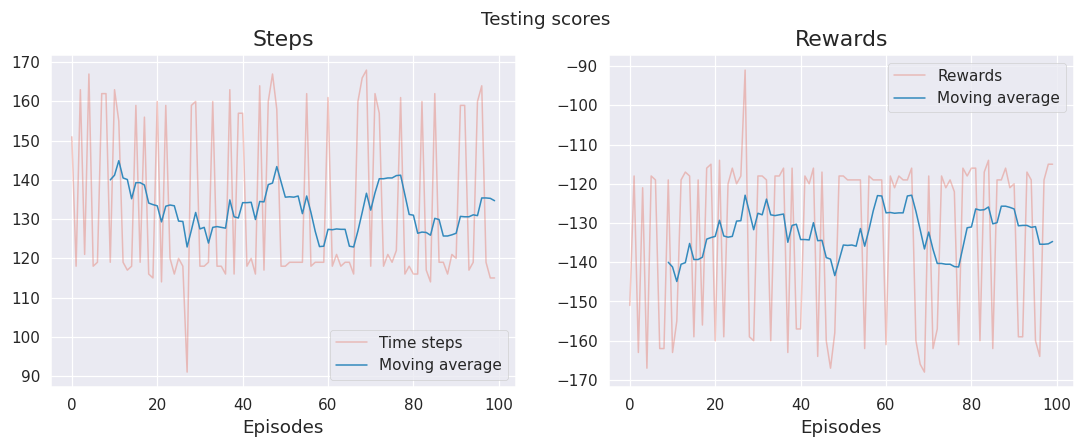

In [0]:
# visualize the test scores
plot_scores(test_df2, rolling_window=10, title='Testing scores', format_ticks=False, filename='qagent2_test')

We expect the average to fall below -110 for the best case scenario.

### Plot Q-table

In [0]:
# display the Q-table
agent2.get_policy()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

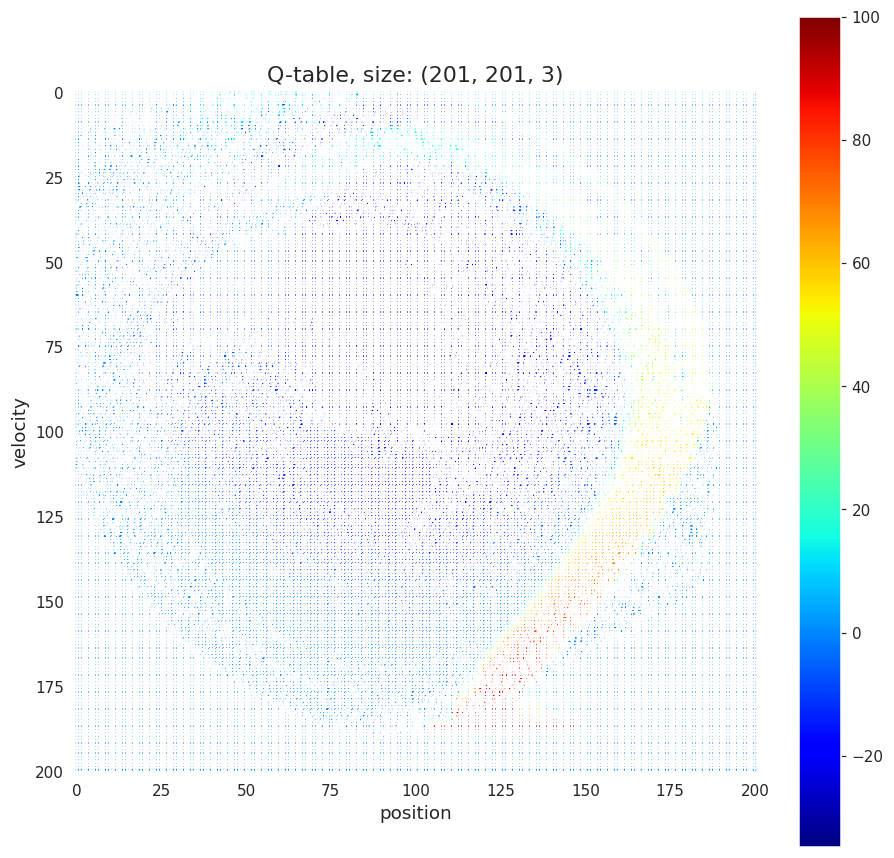

In [0]:
plot_q_table(agent2.Q)

We can observe the position of the Q-values with the best reward indicated in red color

## Trial 3 - keeping Epsilon and gamma constant while increasing Alpha value
```
Epsilon values: start=0.9, end=0.01, decay=0.9999995
Alpha = 0.09
Gamma = 0.98
```

In [0]:
env = make_env(recording_dir='agent3')

In [0]:
# define training agents
strategy2 = EpsilonGreedyStrategy(start=0.9, end=0.05, decay=0.9999995)
agent3 = QAgent(env, strategy2, discrete_states=DISCRETE_STATES, alpha=0.09, gamma=0.98, policy_path='agent3')
agent3

QAgent(alpha=0.09, gamma=0.98, strategy=EpsilonGreedyStrategy(start=0.9, end=0.05, decay=0.9999995))

In [0]:
metrics3 = train(agent3, env, episodes=NUM_EPISODES)

Training complete in 200000 episodes || Best reward: -85.00 || Time spent: 53m 38s, streaks: 188414


In [0]:
show_video('agent3')

### Plot scores

In [0]:
metrics3.tail(100)

,steps,rewards,goal_positions
199900,113,-113.0,1
199901,115,-115.0,1
199902,115,-115.0,1
199903,121,-121.0,1
199904,120,-120.0,1
...,...,...,...
199995,86,-86.0,1
199996,102,-102.0,1
199997,174,-174.0,1
199998,162,-162.0,1


In [0]:
metrics3.describe()

,steps,rewards,goal_positions
count,200000.000000,200000.000000,200000.000000
mean,175.603415,-175.603415,0.942070
std,103.518116,103.518116,0.233612
min,85.000000,-500.000000,0.000000
25%,117.000000,-184.000000,1.000000
50%,128.000000,-128.000000,1.000000
75%,184.000000,-117.000000,1.000000
max,500.000000,-85.000000,1.000000


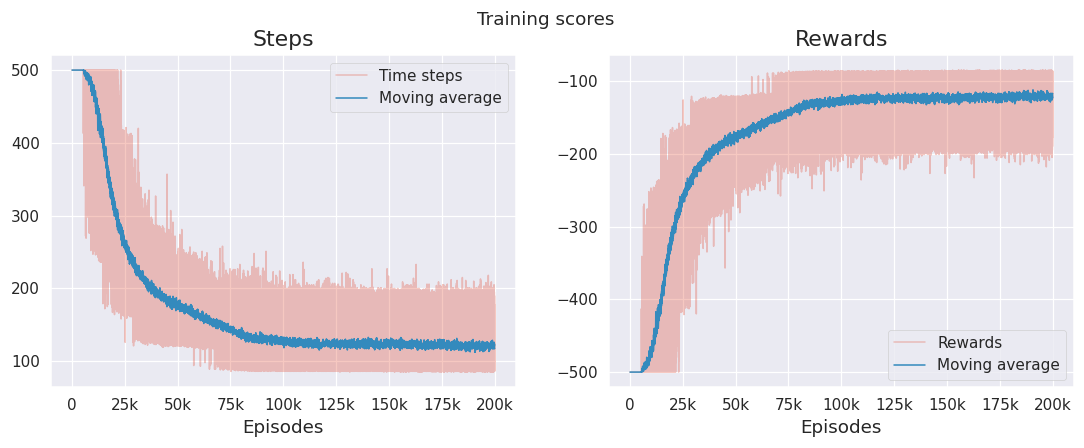

In [0]:
# plot training scores
plot_scores(metrics3, rolling_window=100, filename='agent3')

### Test agent

In [0]:
test_df3 = test(agent3, env)

In [0]:
test_df3

,rewards,steps,goal_position
0,-114.0,114,1
1,-114.0,114,1
2,-113.0,113,1
3,-111.0,111,1
4,-113.0,113,1
...,...,...,...
95,-93.0,93,1
96,-86.0,86,1
97,-89.0,89,1
98,-113.0,113,1


In [0]:
test_df3.describe()

,rewards,steps,goal_position
count,100.000000,100.000000,100.0
mean,-108.490000,108.490000,1.0
std,20.622874,20.622874,0.0
min,-196.000000,85.000000,1.0
25%,-114.000000,93.750000,1.0
50%,-113.000000,113.000000,1.0
75%,-93.750000,114.000000,1.0
max,-85.000000,196.000000,1.0


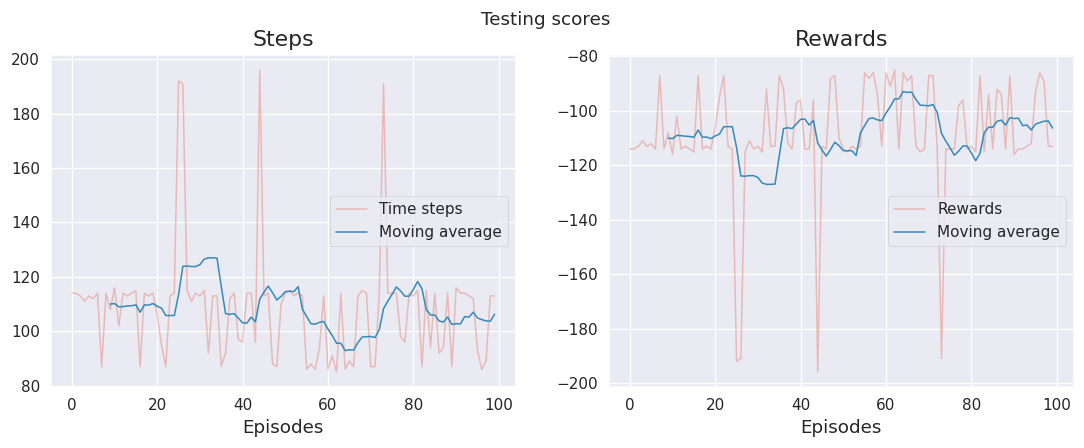

In [0]:
plot_scores(test_df3, rolling_window=10, title='Testing scores', format_ticks=False, filename='qagent3_test')

### Plot Q-table

In [0]:
# display the Q-table
agent3.get_policy()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

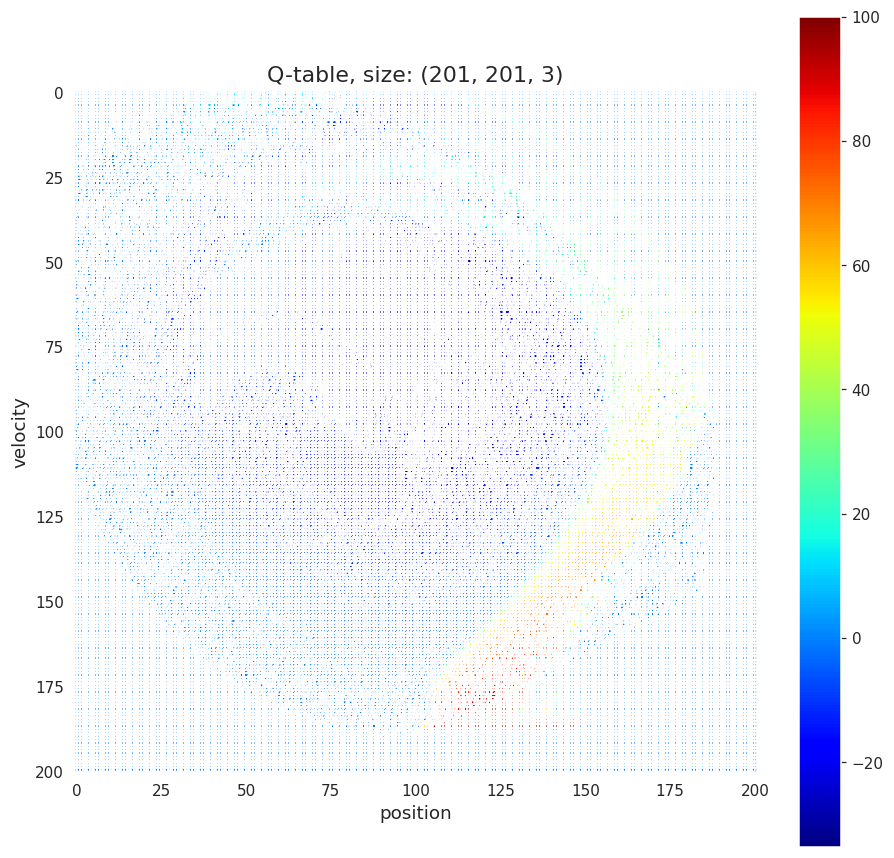

In [0]:
plot_q_table(agent3.Q, filename='agent3')

## Trial 4 - keeping Epsilon and Alpha constant, with lower gamma
```
Epsilon values: start=0.9, end=0.01, decay=0.9999995
Alpha = 0.05
Gamma = 0.8
```

In [0]:
env = make_env(recording_dir='agent4')

In [0]:
# define training agents
strategy2 = EpsilonGreedyStrategy(start=0.9, end=0.05, decay=0.9999995)
agent4 = QAgent(env, strategy2, discrete_states=DISCRETE_STATES, alpha=0.05, gamma=0.8, policy_path='agent4')
agent4

QAgent(alpha=0.05, gamma=0.8, strategy=EpsilonGreedyStrategy(start=0.9, end=0.05, decay=0.9999995))

In [0]:
metrics4 = train(agent4, env, episodes=NUM_EPISODES)

Training complete in 200000 episodes || Best reward: -129.00 || Time spent: 106m 15s, streaks: 127407


In [0]:
show_video('agent4')

### Plot scores

In [0]:
metrics4.tail(100)

,steps,rewards,goal_positions
199900,500,-500.0,0
199901,290,-290.0,1
199902,500,-500.0,0
199903,221,-221.0,1
199904,366,-366.0,1
...,...,...,...
199995,500,-500.0,0
199996,500,-500.0,0
199997,500,-500.0,0
199998,500,-500.0,0


In [0]:
metrics4.describe()

,steps,rewards,goal_positions
count,200000.000000,200000.000000,200000.000000
mean,354.242015,-354.242015,0.637035
std,131.011849,131.011849,0.480856
min,129.000000,-500.000000,0.000000
25%,226.000000,-500.000000,0.000000
50%,326.000000,-326.000000,1.000000
75%,500.000000,-226.000000,1.000000
max,500.000000,-129.000000,1.000000


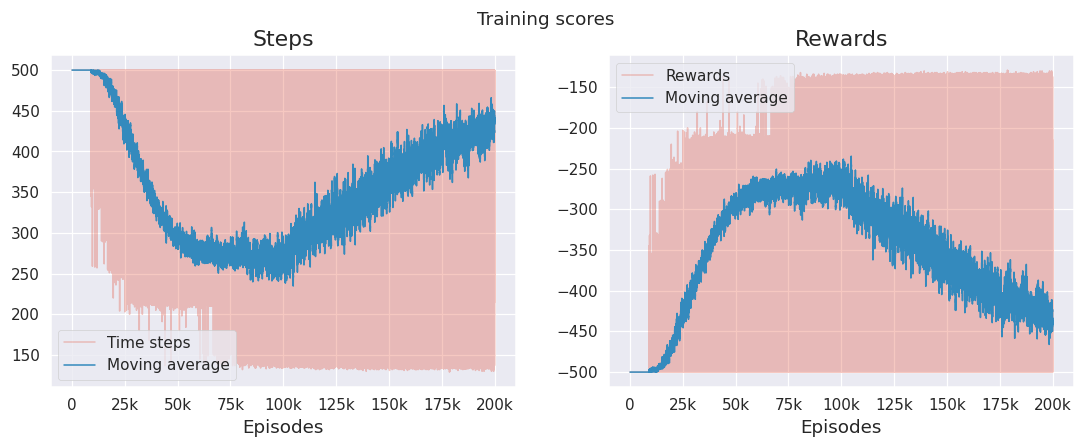

In [0]:
# plot training scores
plot_scores(metrics4, rolling_window=100, filename='agent4')

### Test agent

In [0]:
test_df4 = test(agent4, env)

In [0]:
test_df4

,rewards,steps,goal_position
0,-218.0,218,1
1,-500.0,500,0
2,-500.0,500,0
3,-500.0,500,0
4,-500.0,500,0
...,...,...,...
95,-500.0,500,0
96,-500.0,500,0
97,-500.0,500,0
98,-221.0,221,1


In [0]:
test_df4.describe()

,rewards,steps,goal_position
count,100.000000,100.000000,100.00000
mean,-457.600000,457.600000,0.15000
std,103.833297,103.833297,0.35887
min,-500.000000,135.000000,0.00000
25%,-500.000000,500.000000,0.00000
50%,-500.000000,500.000000,0.00000
75%,-500.000000,500.000000,0.00000
max,-135.000000,500.000000,1.00000


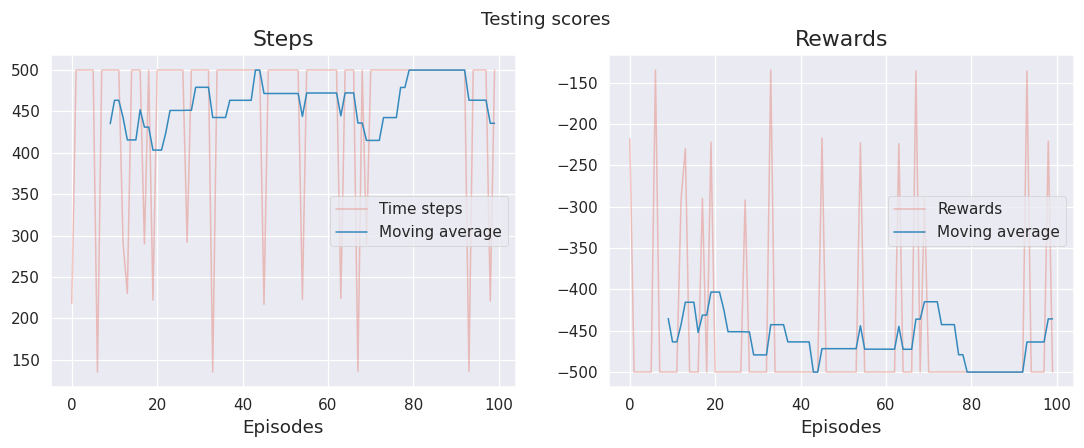

In [0]:
plot_scores(test_df4, rolling_window=10, title='Testing scores', format_ticks=False, filename='agent4_test')

### Plot Q-table

In [0]:
# display the Q-table
agent4.get_policy()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

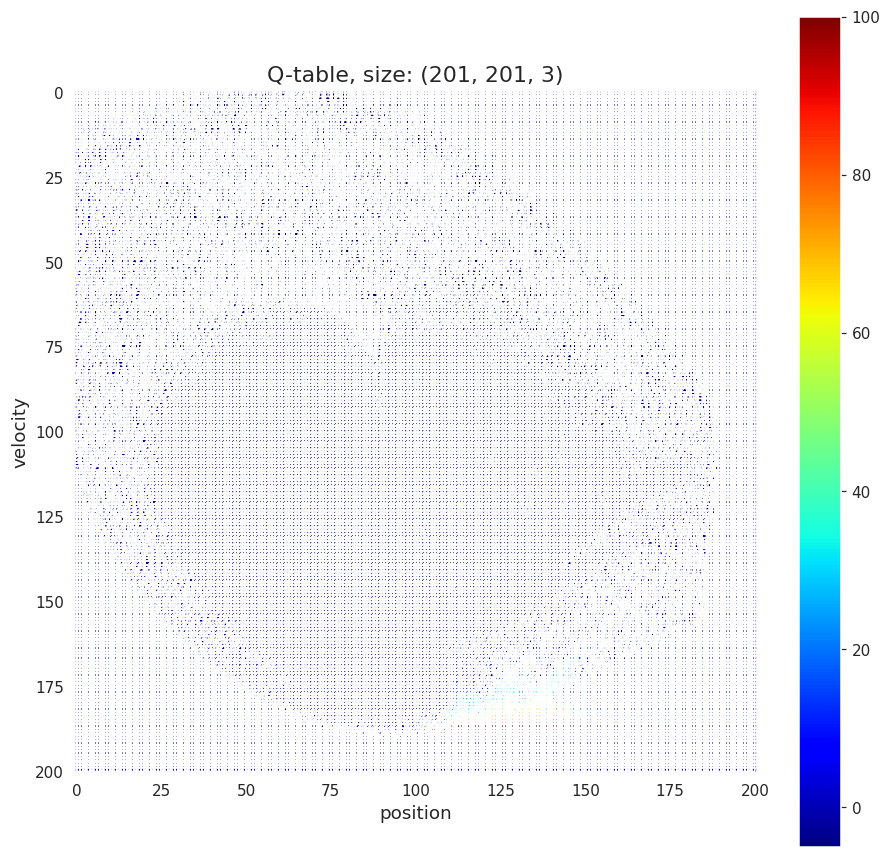

In [0]:
plot_q_table(agent4.Q, filename='agent4')

# Test comparison

## Rewards

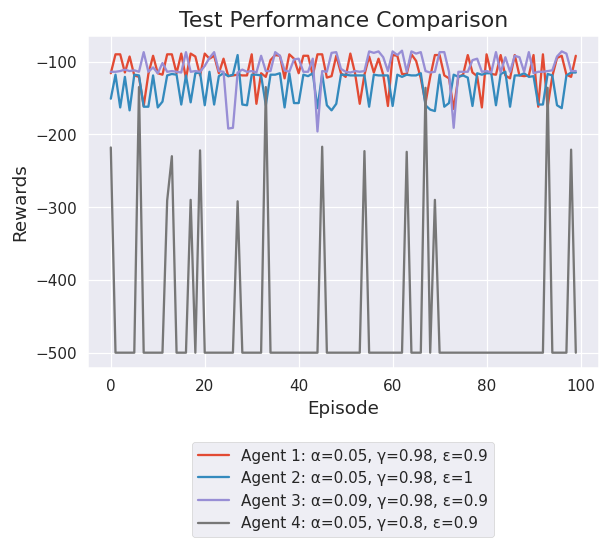

In [0]:
fig, ax = plt.subplots()
ax.plot(test_df.rewards, label='Agent 1: α=0.05, γ=0.98, ε=0.9')
ax.plot(test_df2.rewards, label='Agent 2: α=0.05, γ=0.98, ε=1')
ax.plot(test_df3.rewards, label='Agent 3: α=0.09, γ=0.98, ε=0.9')
ax.plot(test_df4.rewards, label='Agent 4: α=0.05, γ=0.8, ε=0.9')

ax.set_xlabel('Episode')
ax.set_ylabel('Rewards')

plt.title('Test Performance Comparison')
# Put a legend below current axis
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.20))
plt.show()

From the above chart, we observe Agent 2 with alpha of 0.09, gamma 0.98 and epsilon of 0.9 peformed better in the test phase. The worst agent is Agent 3 with lower gamma value. This shows that usinng a low discount factor reduced the performance of the agent.

## Steps

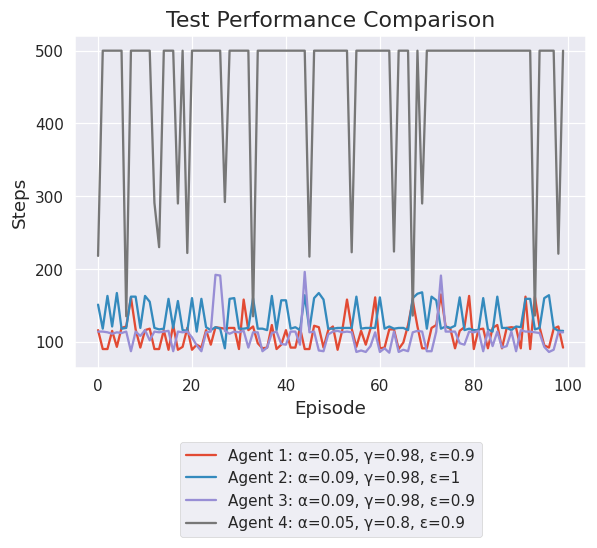

In [0]:
fig, ax = plt.subplots()
ax.plot(test_df.steps, label='Agent 1: α=0.05, γ=0.98, ε=0.9')
ax.plot(test_df2.steps, label='Agent 2: α=0.09, γ=0.98, ε=1')
ax.plot(test_df3.steps, label='Agent 3: α=0.09, γ=0.98, ε=0.9')
ax.plot(test_df4.steps, label='Agent 4: α=0.05, γ=0.8, ε=0.9')

ax.set_xlabel('Episode')
ax.set_ylabel('Steps')

plt.title('Test Performance Comparison')
# Put a legend below current axis
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.20))
plt.show()

## Goal position

Here we plot number of times the car reached the goal position

In [0]:
test_goal_df = pd.DataFrame([
    {'Agent': 'Agent 1', 'count': test_df.goal_position.sum(),},
    {'Agent': 'Agent 2', 'count': test_df2.goal_position.sum(), },
    {'Agent': 'Agent 3', 'count': test_df3.goal_position.sum(), },
    {'Agent': 'Agent 4', 'count': test_df4.goal_position.sum(),},
])
train_goal_df = pd.DataFrame([
    {'Agent': 'Agent 1', 'count': metrics.goal_positions.sum()},
    {'Agent': 'Agent 2', 'count': metrics2.goal_positions.sum()},
    {'Agent': 'Agent 3', 'count': metrics3.goal_positions.sum()},
    {'Agent': 'Agent 4', 'count': metrics4.goal_positions.sum()}
])

### Training phase

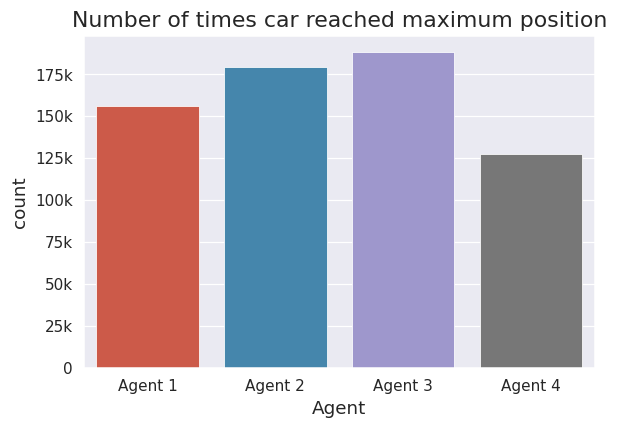

In [0]:
ax = sns.barplot('Agent', 'count', data=train_goal_df)
yticks = [millify(y) for y in ax.get_yticks()]
ax.set_yticklabels(yticks)

plt.title('Number of times car reached maximum position')
plt.show()

### Testing phase

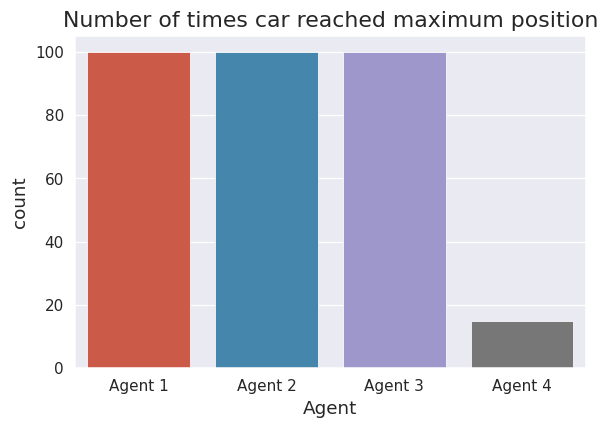

In [0]:
sns.barplot('Agent', 'count', data=test_goal_df)
plt.title('Number of times car reached maximum position')
plt.show()